In [1]:
%matplotlib inline
import matplotlib.pylab as plt

from PIL import Image
import numpy as np
from scipy.misc import imresize
import glob, threading, bcolz, os, time, pickle
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

from vgg16 import VGG16
import keras.backend as K
from keras.models import Model
from keras.callbacks import History 
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

dpath = '../../fastdata/dl1data/dogscats/'
desired_shp = 224

Using TensorFlow backend.


In [2]:
limit_mem() #from utils

## What are the Different Methods we can use to Reshape an Image

- Working with the dogs and cats data set from Kaggle
- Goal: Understand impact of image resizing on model training time and performance
- Pros: Keeps all image data, without adding any black boxes
- Cons: Aspect ratio often changes, so this could make training more difficult

In [3]:
fnames = list(glob.iglob(dpath + 'sample/train/*/*.jpg'))
orig = Image.open(fnames[2]); print(orig.size)

(500, 307)


## Option 1: Squashing to square
- This is the same result we get when using Keras' ImageDataGenerator() so in many ways this is my baseline

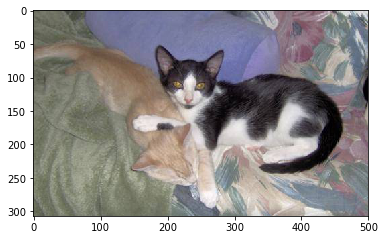

In [4]:
orig_arr = np.array(orig)
plt.imshow(orig_arr)

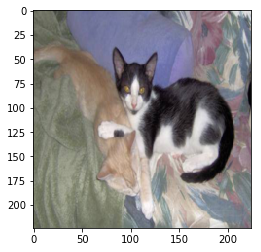

In [5]:
resized = imresize(orig_arr, (desired_shp,desired_shp))
plt.imshow(resized)

## Option 2: Keep Aspect Ratio and Crop Shortest Side to desired_shp
- Here we keep the aspect ratio the same, but lose some of the image
- Pros: Aspect ratio is changed
- Con: Some information is lost in the cropping step, could be problematic if your image is not centered

In [6]:
def resize_center_crop(im_arr, desired_shp = 224):
    x,y,_ = im_arr.shape
    ratio = 1.0 * x/y
    if x < y:
        newx, newy = desired_shp, desired_shp/ratio
    elif y < x:
        newx, newy = desired_shp * ratio, desired_shp
    else :
        newx, newy = desired_shp,desired_shp
    newshape = (int(newx), int(newy))
    
    #Resize based shortest side to 'desired_shp'
    im_arr = imresize(im_arr, newshape)
    
    #center crop so both side are equal length
    left, right = (newx - desired_shp)/2, (newx + desired_shp)/2
    top, bottom = (newy - desired_shp)/2, (newy + desired_shp)/2
    return im_arr[left:right,top:bottom]


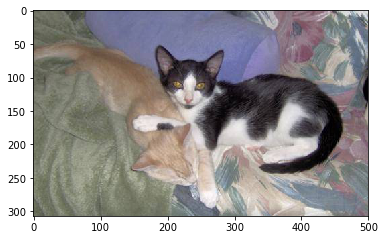

In [7]:
plt.imshow(orig_arr)

/home/otto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


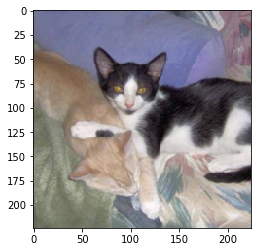

In [8]:
center_cropped = resize_center_crop(orig_arr)
plt.imshow(center_cropped)

## Option 3: Add black borders to make square, then center crop
- Pro: No information is lost in a crop and we also maintain the aspect ratio
- Con: By adding the black borders, we are adding noise to the image which the network needs to learn to ignore. 

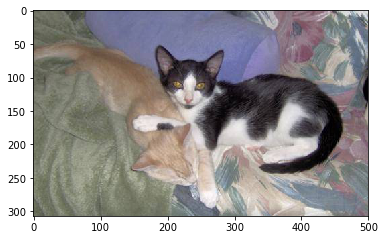

In [9]:
orig_arr = np.array(orig)
plt.imshow(orig_arr)

/home/otto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


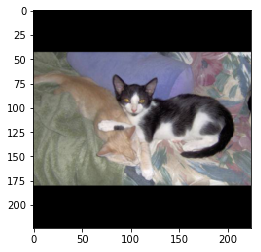

In [10]:
def mk_square(img, desired_shp=224):
    x,y,_ = img.shape
    maxs = max(img.shape[:2])
    y2=(maxs-y)//2
    x2=(maxs-x)//2
    arr = np.zeros((maxs,maxs,3), dtype=np.float32)
    arr[np.floor(x2):np.floor(x2)+x,np.floor(y2):np.floor(y2)+y] = img
    return imresize(arr, (desired_shp,desired_shp))

resized_square = mk_square(orig_arr)
plt.imshow(resized_square)

### Lets Build some Arrays with Images Resized by Each Method Shown Above
- Using pythons threading to run this in parallel on the CPU (credit to Jeremy Howard for the demo

In [12]:
# #Setup data dirs
# if not os.path.exists(f'{dpath}/resized/'): os.mkdir(f'{dpath}/resized/')
# for data_group in ['train', 'test1', 'valid']:
#     for method in fn_info.keys():
#         if not os.path.exists(f'{dpath}/resized/{method}/'): 
#             os.mkdir(f'{dpath}/resized/{method}/')

In [13]:
   
def resize_img_1(i ,desired_shp=224):
    '''Squashes to square, regardless of aspect ratio'''
    orig_arr = np.array(Image.open(fnames[i]))
    return imresize(orig_arr, (desired_shp,desired_shp))

def resize_img_2(i ,desired_shp=224):
    '''Resizes shortest side to 224, then centercrops'''
    orig_arr = np.array(Image.open(fnames[i]))
    return resize_center_crop(orig_arr, desired_shp)

def resize_img_3(i ,desired_shp=224):
    '''Converts to a square image with black borders to retain aspect ratio'''
    orig_arr = np.array(Image.open(fnames[i]))
    return mk_square(orig_arr, desired_shp)

fn_info = {
    'squash':resize_img_1,
    'center_crop':resize_img_2,
    'black_border':resize_img_3
    }

In [19]:
#Create pre-allocated memory to speed things up
tl = threading.local()
tl.place = np.zeros((desired_shp,desired_shp,3), 'uint8')

def app_img(r):
    tl.place[:] = np.array(r)[0:desired_shp, 0:desired_shp]
    arr.append(tl.place) 


#For each data set, get filenames and parallel resize. 
for data_group in ['train', 'test1', 'valid']:
    fnames = list(glob.iglob(dpath + f'/{data_group}/*/*.jpg'))
    for method in fn_info.keys():
        fn = fn_info[method]
        bc_path = f'{dpath}/resized/{method}/{method}_{data_group}_{desired_shp}_r.bc'
        arr = bcolz.carray(np.empty((0, desired_shp, desired_shp, 3), 'float32'), 
                       chunklen=32, mode='w', rootdir=bc_path)
        step, n =6400, len(fnames)
        for i in range(0, n, step):
            with ThreadPoolExecutor(max_workers=16) as execr:
                res = execr.map(fn, range(i, min(i+step, n)))
                for r in res: app_img(r)
            arr.flush()

In [147]:
#For each data set, create class labels we can use in training
def get_classes(data_group):
    fnames = list(glob.iglob(dpath + f'/{data_group}/*/*.jpg'))
    fnames = [f.split('/')[-1].split('.')[0] for f in fnames]
    fnames = [1 if f == 'cat' else 0 for f in fnames ]
    return to_categorical(fnames)

for data_group in ['train', 'test1', 'valid']:
    class_path = f'{dpath}/resized/{data_group}_classes.bc'
    save_array(class_path, get_classes(data_group))

## Load Arrays and Generate VGG Output Features
- We'll use these as inputs to the Conv Model in the next step
- This allows us to focus on fine tuning the top end of the model and speed up epochs

In [15]:
# Generate VGG Convolutional Features
methods = ['center_crop', 'squash', 'black_border']
for method in methods:
    trn = load_array(f'{dpath}/resized/{method}/{method}_train_{desired_shp}_r.bc')
    val = load_array(f'{dpath}/resized/{method}/{method}_valid_{desired_shp}_r.bc')
    tst = load_array(f'{dpath}/resized/{method}/{method}_test1_{desired_shp}_r.bc')

    print(trn.shape, tst.shape, val.shape)

    vgg = VGG16(include_top=False, weights='imagenet')

    conv_val_ftrs = vgg.predict(val)
    conv_trn_ftrs = vgg.predict(trn)
    conv_tst_ftrs = vgg.predict(tst)

    save_array(f'{dpath}/resized/{method}/{method}_val_{desired_shp}_vggout.bc', conv_val_ftrs)
    save_array(f'{dpath}/resized/{method}/{method}_trn_{desired_shp}_vggout.bc', conv_trn_ftrs)
    save_array(f'{dpath}/resized/{method}/{method}_tst_{desired_shp}_vggout.bc', conv_tst_ftrs)

    del trn, val, tst
    del vgg

(23000, 224, 224, 3) (12500, 224, 224, 3) (2000, 224, 224, 3)
(23000, 224, 224, 3) (12500, 224, 224, 3) (2000, 224, 224, 3)
(23000, 224, 224, 3) (12500, 224, 224, 3) (2000, 224, 224, 3)


## Load the Conv Features, Get Class Labels and Train
- For each method, we'll train a model for many epochs and see what happens

In [3]:
def build_model(inp_shape, p=.5):
    inp = Input(shape=inp_shape)
    x = Flatten(name='flatten')(inp)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(4096, activation='relu', name='fc3')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    preds = Dense(2, activation='softmax', name='predictions')(x)

    model = Model(inp, preds)
    model.compile(Adam(lr=1E-4), 'binary_crossentropy', metrics=['accuracy'])
    return model

def generate_batches(data_arr, class_arr, batch_size):
    '''Custom generator to pass some data to the model'''
    steps = data_arr.shape[0] // batch_size
    rand_idx = np.random.permutation(range(len(data_arr)))
    data_arr = data_arr[rand_idx]
    class_arr = class_arr[rand_idx]
    while 1:
        for step in range(steps):
            data = data_arr[step * batch_size:(step+1) * batch_size]
            classes = class_arr[step * batch_size:(step+1) * batch_size]
        yield (data, classes)



In [4]:
trn_cls = load_array(f'{dpath}/resized/train_classes.bc')
val_cls = load_array(f'{dpath}/resized/valid_classes.bc')

In [ ]:
model = None
for method in methods:
    print(f'Starting {method}')
    conv_val_ftrs = load_array(f'{dpath}/resized/{method}/{method}_val_{desired_shp}_vggout.bc')
    conv_trn_ftrs = load_array(f'{dpath}/resized/{method}/{method}_trn_{desired_shp}_vggout.bc')
    conv_tst_ftrs = load_array(f'{dpath}/resized/{method}/{method}_tst_{desired_shp}_vggout.bc')

    batch_size, n_epoch = 256, 20
    n_trn, n_val = 10 * batch_size, 5 * batch_size
    trn_batches = generate_batches(conv_trn_ftrs, trn_cls, batch_size)
    val_batches = generate_batches(conv_val_ftrs, val_cls, batch_size)
    model = build_model(conv_trn_ftrs.shape[1:])
    history_cb = History() #keras callback for storing history of training
    results = model.fit_generator(trn_batches, samples_per_epoch=n_trn, nb_epoch=n_epoch,
                                  validation_data=val_batches, nb_val_samples=n_val,
                                  callbacks = [history_cb], verbose=0)
    history_path = f'{dpath}/resized/history_{method}.pkl'
    pickle.dump(results.history,open(history_path, 'wb'))    
    del model


## Load Results from Each Run and Plot

In [7]:
histories = {}
for method in methods:
    history_path = f'{dpath}/resized/history_{method}.pkl'
    h = pickle.load(open(history_path, 'rb'))
    histories[method] = h

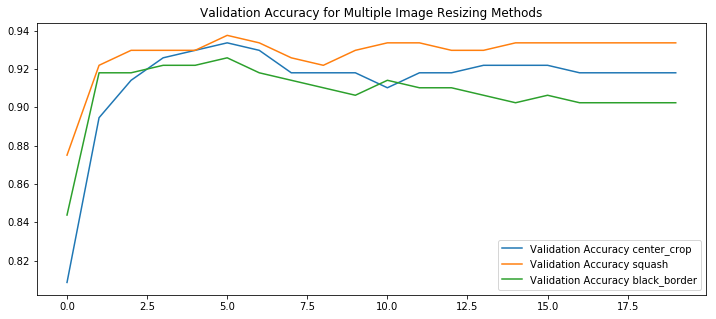

In [14]:
history = histories['center_crop']
fig = plt.figure(figsize=(12,5))
for method in methods:
    plt.plot(histories[method]['val_acc'], label=f'Validation Accuracy {method}')
plt.legend()
plt.title('Validation Accuracy for Multiple Image Resizing Methods')
plt.show()
fig.savefig('./validation_acc.png')

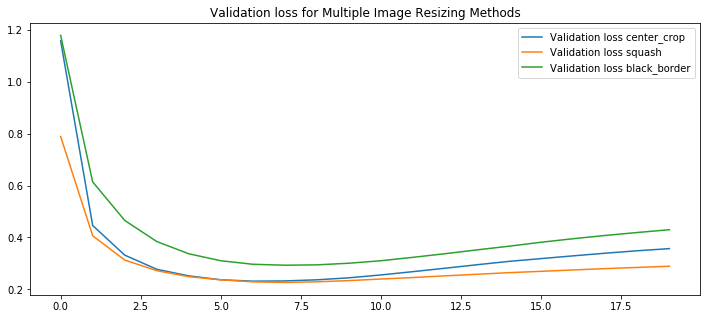

In [15]:
history = histories['center_crop']
fig = plt.figure(figsize=(12,5))
for method in methods:
    plt.plot(histories[method]['val_loss'], label=f'Validation loss {method}')
plt.legend()
plt.title('Validation loss for Multiple Image Resizing Methods')
plt.show()
fig.savefig('./validation_loss.png')